# Preparation

In [1]:
import pandas as pd
import numpy as np
from numpy import expand_dims

#library to read and import file from drive
import os
import zipfile
from shutil import copyfile

from sklearn.model_selection import train_test_split

#images
from google.colab.patches import cv2_imshow
import cv2 as cv
import matplotlib.pyplot as plt
#!pip install seaborn_image
import seaborn_image as isns

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Functions

In [19]:
#function to crop image 
def crop(img, mask=False):
  #gaussian filter
  tmp = cv.GaussianBlur(img,(5,5),0)

  ret1, th1 = cv.threshold(tmp[:,:,2], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
  ret2, th2 = cv.threshold(img[:,:,2],120, 255, cv.THRESH_BINARY)

  x, y, w, h = cv.boundingRect(th1)
 
  #return input image with crop and in b&w
  border = 0
  if(mask):
    return cv.resize(th2[y-border:y+h+border, x-border:x+w+border], (224,224))
  return cv.resize(img[y-border:y+h+border, x-border:x+w+border], (224,224))

In [35]:
#function to create prepared dataset with cropped images
def prepared_dataset(dir='./'):
  for folder in os.listdir(dir):
    for img in os.listdir(dir + '/' + folder):
      image = cv.imread((dir + '/' + folder + '/' + img))
      image = crop(image)
      if folder == "NOK":
        cv.imwrite("../Data/Preprocessed/NOK/"+img, image)
      else:
        cv.imwrite("../Data/Preprocessed/OK/"+img, image)

In [7]:
# Load photos and extract faces
def data_loader(dir='./'):
  imgs = []
  labels = []
  for folder in os.listdir(dir):
    for img in os.listdir(dir + '/' + folder):
      image = cv.imread((dir + '/' + folder + '/' + img))
      imgs.append(image)
      if folder == "NOK":
        labels.append(1)
      else:
        labels.append(0)
  return train_test_split(imgs, labels, test_size=0.2, random_state=1, stratify=labels)

## Dataset load

In [2]:
# Link Google Drive account, transfer dataset, and extract files
from google.colab import drive
drive.mount('/content/gdrive')

copyfile('gdrive/My Drive/Train.zip', 'Train.zip')
zip = zipfile.ZipFile('Train.zip')
zip.extractall()
zip.close()

Mounted at /content/gdrive


## Data exploration and visualization

#### Number of images for each class

In [3]:
list_NOK = os.listdir("/content/Train/NOK")
list_OK = os.listdir("/content/Train/OK")
number_NOK = len(list_NOK)
number_OK = len(list_OK)
print("The number of NO ok images is:", number_NOK)
print("The number of ok images is:", number_OK)

The number of NO ok images is: 15
The number of ok images is: 84


#### Example of OK and NOK images

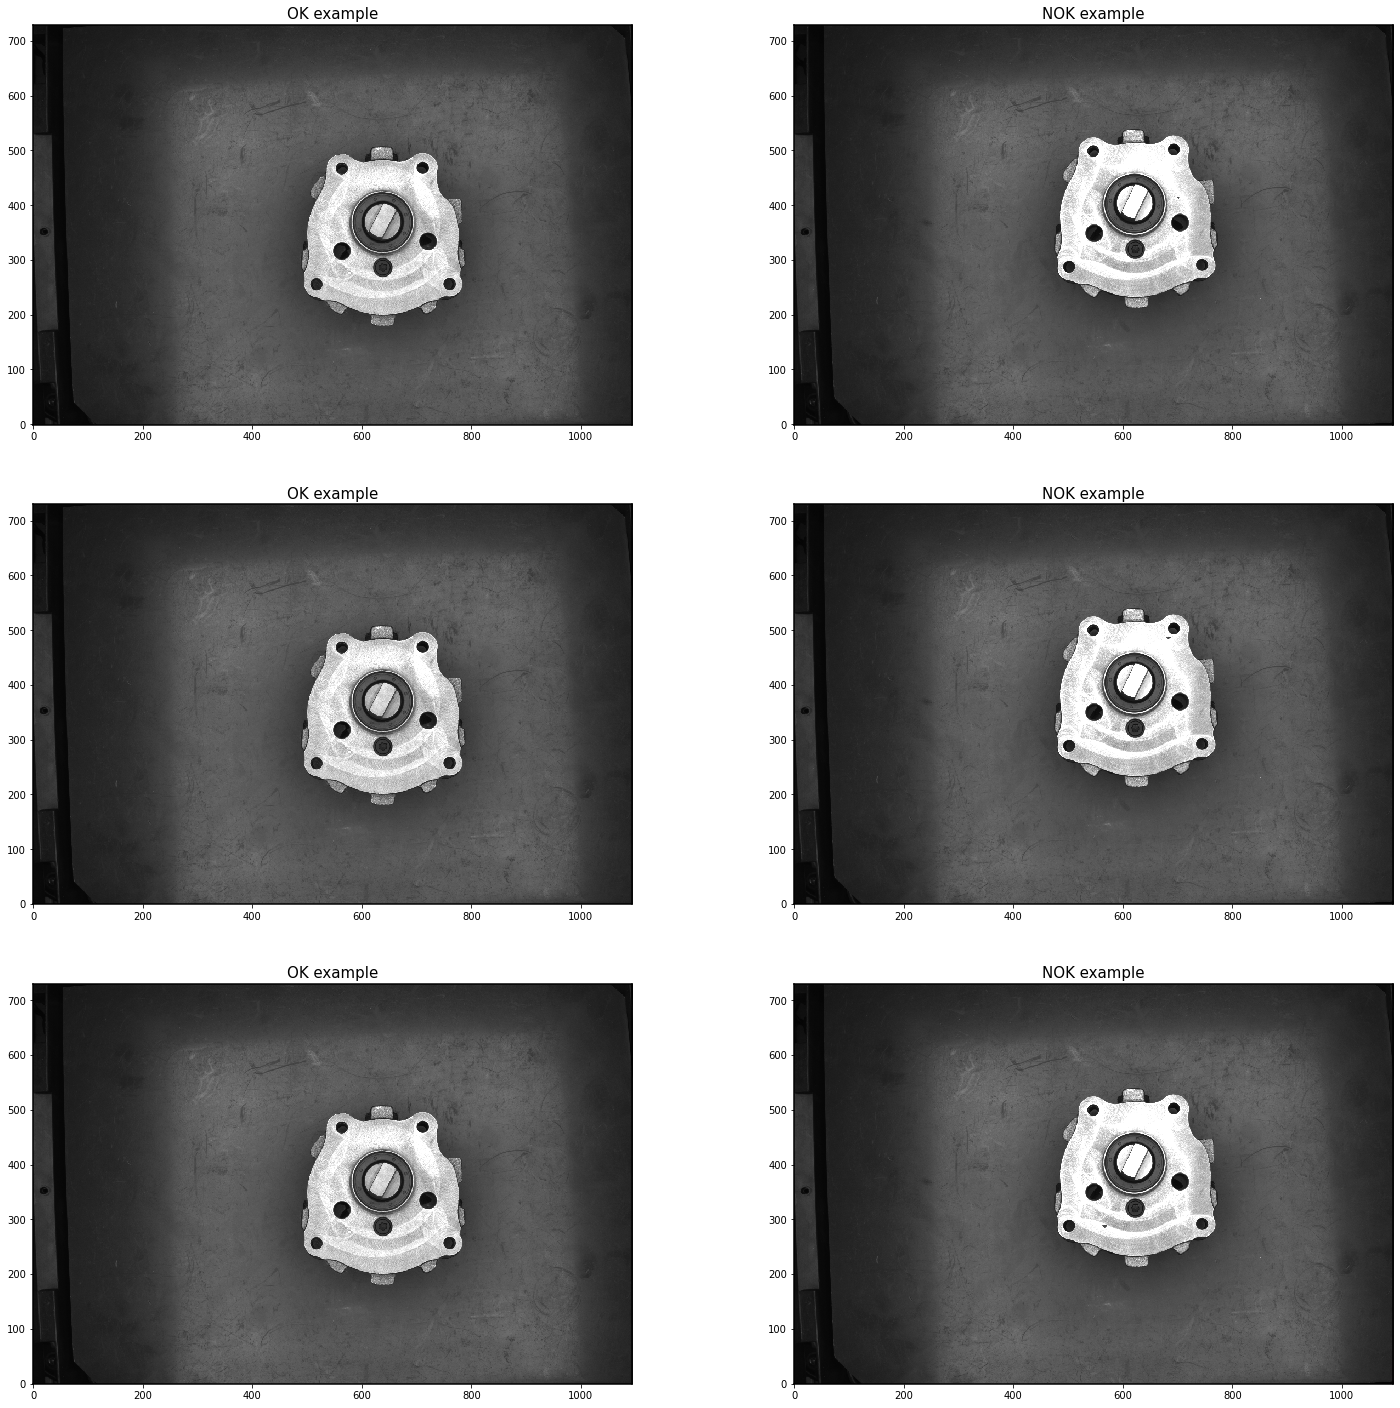

In [4]:
example_nok1 = cv.imread("/content/Train/NOK/NOK (18).bmp")
example_ok1 = cv.imread("/content/Train/OK/OK (1).bmp")
example_nok2 = cv.imread("/content/Train/NOK/NOK (15).bmp")
example_ok2 = cv.imread("/content/Train/OK/OK (2).bmp")
example_nok3 = cv.imread("/content/Train/NOK/NOK (16).bmp")
example_ok3 = cv.imread("/content/Train/OK/OK (3).bmp")
example_ok1 = cv.resize(example_ok1, (None), fx=0.2, fy=0.2)
example_nok1 = cv.resize(example_nok1, (None), fx=0.2, fy=0.2)
example_ok2 = cv.resize(example_ok2, (None), fx=0.2, fy=0.2)
example_nok2 = cv.resize(example_nok2, (None), fx=0.2, fy=0.2)
example_ok3 = cv.resize(example_ok3, (None), fx=0.2, fy=0.2)
example_nok3 = cv.resize(example_nok3, (None), fx=0.2, fy=0.2)

plt.figure(figsize=(25,25))

plt.subplot(3,2,1)
plt.title("OK example")
plt.imshow(example_ok1)
plt.subplot(3,2,2)
plt.title("NOK example")
plt.imshow(example_nok1)
plt.subplot(3,2,3)
plt.title("OK example")
plt.imshow(example_ok2)
plt.subplot(3,2,4)
plt.title("NOK example")
plt.imshow(example_nok2)
plt.subplot(3,2,5)
plt.title("OK example")
plt.imshow(example_ok3)
plt.subplot(3,2,6)
plt.title("NOK example")
plt.imshow(example_nok3)

Da queste immagini si può notare come la caratteristica principale delle immagini NOK è quella di presentare delle piccole macchie nere sulla superficie del pezzo (dovuto alla mancanza di materiale).
Si osserva che le dimensioni dei difetti sono molto ridotte e questo fatto dovrà essere tenuto in considerazione nella fase di selezione del modello.

### Histogram images comparison

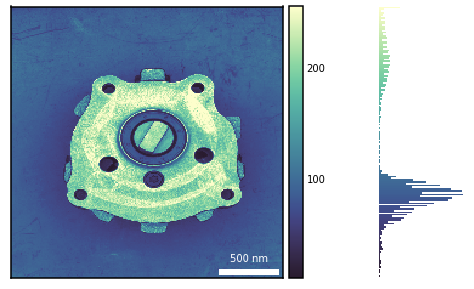

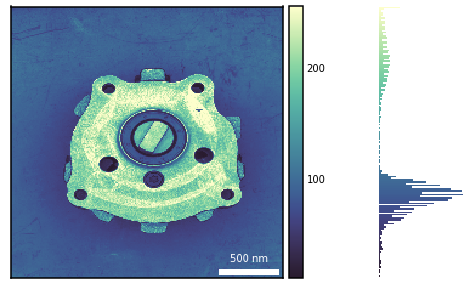

In [34]:
example_ok = cv.imread("/content/Train/OK/OK (1).bmp")
example_nok = cv.imread("/content/Train/NOK/NOK (7).bmp")

example_crop_ok = crop(example_ok)
example_crop_nok = crop(example_nok)
f = isns.imghist(example_crop_ok[:, :, 0], dx=0.01, units="um")
j = isns.imghist(example_crop_nok[:, :, 0], dx=0.01, units="um")

In [29]:
type(f)

matplotlib.figure.Figure

## Cleaning

#### Crop production piece from image

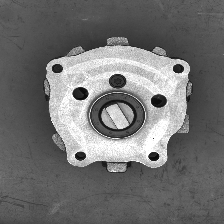

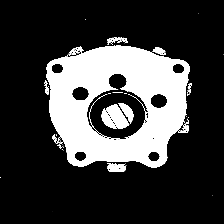

In [21]:
#example of crop function
example_tmp_nok1 = cv.imread("/content/Train/NOK/NOK (6).bmp")

cv2_imshow(crop(example_tmp_nok1))
cv2_imshow(crop(example_tmp_nok1, True))

## Save prepared dataset

In [36]:
prepared_dataset("/content/Train")

# Training

## Model CNN

In [ ]:
X_train, X_val, y_train, y_val = data_loader("./Train")

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
y_train = np.array(y_train)

In [ ]:
# Load a pre-trained neural network to use for transfer learning
base_net = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

# Set the layers of the base net to not be trained
for layer in base_net.layers:
  layer.trainable=False


In [ ]:
# Add to the MobileNetV2 and 2 dense layer to adapt the net to our problem
inputs = keras.Input(shape=(224,224,3))
x = inputs

x = keras.applications.mobilenet_v2.preprocess_input(x)

x = base_net(x)

x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)
outputs = x

In [ ]:
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
net.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=["Accuracy"])

In [ ]:
net.fit(X_train, y_train, batch_size=16, epochs=50, validation_data = (X_val, y_val), class_weight={0:1,1:4})

Epoch 1/50
5/5 [==============================] - 5s 991ms/step - loss: 0.9767 - Accuracy: 0.8734 - val_loss: 0.5414 - val_Accuracy: 0.8500
Epoch 2/50
5/5 [==============================] - 4s 739ms/step - loss: 0.9878 - Accuracy: 0.8481 - val_loss: 0.6544 - val_Accuracy: 0.6500
Epoch 3/50
5/5 [==============================] - 3s 733ms/step - loss: 0.9474 - Accuracy: 0.6962 - val_loss: 0.4815 - val_Accuracy: 0.8500
Epoch 4/50
5/5 [==============================] - 3s 700ms/step - loss: 1.0004 - Accuracy: 0.8228 - val_loss: 0.6626 - val_Accuracy: 0.6500
Epoch 5/50
5/5 [==============================] - 3s 729ms/step - loss: 0.9770 - Accuracy: 0.8101 - val_loss: 0.7215 - val_Accuracy: 0.4000
Epoch 6/50
5/5 [==============================] - 3s 704ms/step - loss: 0.9297 - Accuracy: 0.5570 - val_loss: 0.4762 - val_Accuracy: 0.8500
Epoch 7/50
5/5 [==============================] - 4s 756ms/step - loss: 1.0043 - Accuracy: 0.8481 - val_loss: 0.7045 - val_Accuracy: 0.4000
Epoch 8/50
5/5 [====

In [ ]:
type(X_train)

list